In [2]:
import sys
sys.path.append("..")
import ProbabilisticParcellation.util as ut
import ProbabilisticParcellation.hierarchical_clustering as cl
import ProbabilisticParcellation.similarity_colormap as cm
import ProbabilisticParcellation.functional_profiles as fp
from ProbabilisticParcellation.scripts.atlas_paper.ridge_reg import ridgeFit

from Functional_Fusion.dataset import *
import matplotlib.pyplot as plt
import string
import PcmPy as pcm
from copy import deepcopy
import torch as pt



base_dir = '/Volumes/diedrichsen_data$/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/FunctionalFusion'
if not Path(base_dir).exists():
    base_dir = '/Users/callithrix/Documents/Projects/Functional_Fusion/'
if not Path(base_dir).exists():
    raise (NameError('Could not find base_dir'))
    

## Load profile data and model

In [3]:
atlas = 'MNISymC2'

# load model
mname = f'/Models_03/NettekovenSym32_space-MNISymC2'
fileparts = mname.split('/')
split_mn = fileparts[-1].split('_')
# info, model = ut.load_batch_best(mname)


# load labels and cmap
lut_dir = '/Volumes/diedrichsen_data$/data/Cerebellum/ProbabilisticParcellationModel/Atlases/'
_, cmap, labels = nt.read_lut(lut_dir +
                              f'{split_mn[0]}.lut')
labels=labels[1:]

# load profile
profile_orig = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/{fileparts[-1].split("_")[0]}_profile_individ.tsv', sep="\t"
)

In [4]:
# Reduce profile to only MDTB Tasks
profile_orig = profile_orig[profile_orig.dataset == 'MDTB']
# Make condition into row index and drop everything other than parcel columns
profile_orig = profile_orig.set_index('condition')
profile = deepcopy(profile_orig)
profile = profile[labels]

# Make profile into matrix
profile_mat = profile[labels].to_numpy()

# Subtract the mean profile
profile_mat = (profile_mat - np.mean(profile_mat, axis=0))


In [5]:
profile

M1L       M2L       M3L       M4L       A1L       A2L  \
condition                                                                       
NoGo              -0.050988 -0.083225 -0.050672 -0.038977 -0.078091 -0.071654   
Go                -0.024925 -0.042943  0.046769 -0.009116  0.038274  0.016616   
ToM                0.039167 -0.047212 -0.009360  0.000287 -0.042081 -0.045422   
VideoAct           0.031029  0.097397  0.000205  0.024755 -0.002621  0.038718   
VideoKnots         0.082561  0.115376 -0.010331  0.016825  0.015412  0.029245   
...                     ...       ...       ...       ...       ...       ...   
VisualSearchLarge  0.043007 -0.017649  0.029672  0.008746  0.003778  0.026488   
ToM                0.001802 -0.057650 -0.004984  0.005124 -0.020425 -0.021122   
VideoAct          -0.023242  0.071010 -0.009898 -0.013885 -0.044010  0.007529   
VideoKnots         0.011007  0.033856 -0.006354  0.013865 -0.028562 -0.008086   
rest              -0.018189 -0.024121 -0.011132  0.019594 -0.002463 -0.011981   

                        A3L       A4L       D1L       D2L  ...       A3R  \
condition                                                  ...             
NoGo              -0.070763 -0.080541 -0.062205 -0.055896  ... -0.100003   
Go                -0.000428 -0.037574 -0.022577 -0.035122  ... -0.034102   
ToM               -0.051574 -0.010573 -0.007488 -0.056717  ... -0.041334   
VideoAct           0.109467  0.078395  0.020982  0.024190  ...  0.102058   
VideoKnots         0.035323  0.102416  0.121161  0.047852  ...  0.018326   
...                     ...       ...       ...       ...  ...       ...   
VisualSearchLarge  0.016300  0.004836 -0.005765  0.004677  ... -0.011919   
ToM               -0.030173 -0.016059 -0.008418 -0.037974  ... -0.035968   
VideoAct           0.082159  0.036628 -0.049083 -0.043347  ...  0.062098   
VideoKnots         0.023491  0.033886 -0.022138 -0.017401  ...  0.007933   
rest              -0.025029 -0.003409 -0.028074  0.013364  ... -0.011344   

                        A4R       D1R       D2R       D3R       D4R       S1R  \
condition                                                                       
NoGo              -0.067240 -0.026942 -0.034652 -0.070393 -0.062656 -0.026089   
Go                -0.046799  0.022136 -0.035058 -0.000537  0.007731  0.024291   
ToM                0.027256  0.061164  0.033070  0.052965  0.028804  0.119263   
VideoAct           0.080340  0.028899  0.009521  0.028889  0.034373  0.051552   
VideoKnots         0.096888  0.085777  0.041034  0.060181  0.057947  0.109752   
...                     ...       ...       ...       ...       ...       ...   
VisualSearchLarge  0.006579 -0.007918  0.000014 -0.023707 -0.025055 -0.018495   
ToM               -0.020995  0.042938 -0.013025  0.037292  0.021588  0.091221   
VideoAct           0.031354 -0.064976 -0.021240 -0.013741 -0.046787 -0.028940   
VideoKnots         0.027004 -0.045389 -0.003080 -0.019743 -0.033515 -0.011631   
rest              -0.010472 -0.032569  0.022179 -0.021153 -0.001033  0.017854   

                        S2R       S3R       S4R  
condition                                        
NoGo              -0.020075 -0.021307 -0.028467  
Go                -0.008567 -0.034011 -0.030083  
ToM                0.149913  0.036145  0.019710  
VideoAct           0.037544  0.012060  0.016027  
VideoKnots         0.089295  0.036053  0.009194  
...                     ...       ...       ...  
VisualSearchLarge  0.001416  0.027567 -0.002870  
ToM                0.108481  0.021405  0.014132  
VideoAct          -0.005413 -0.004883 -0.012738  
VideoKnots         0.021188  0.028295  0.015570  
rest               0.067807  0.037054  0.066715  

[1464 rows x 32 columns]

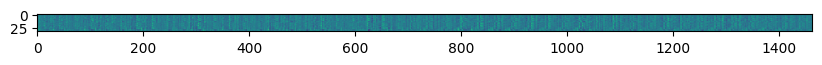

In [6]:
figsize = (10, 10)
plt.figure(figsize=figsize)
plt.imshow(profile_mat.T)

### Load cognitive feature tags

In [7]:
# Load cognitive features
tags = pd.read_csv(
    f'{ut.model_dir}/Atlases/Profiles/tags/tags_final.tsv', sep="\t"
)
# Reduce tags to only MDTB Tasks
tags = tags[tags.dataset == 'MDTB']
# Make condition into index 
tags = tags.set_index('condition')

# Drop everything other than mdtb tags
tags_first_tag_column = tags.columns.tolist().index('left_hand_response_execution')
last_mdtb_tag = tags.columns.tolist().index('right_toe_response_execution')
tags = tags.iloc[:, tags_first_tag_column:last_mdtb_tag]

In [8]:
tags.to_numpy().max()

7.0

In [9]:
tags.response_alternative[-40:]

condition
StroopIncon          4
StroopCon            4
VerbGen              0
WordRead             0
VisualSearchEasy     2
VisualSearchMed      2
VisualSearchDiff     2
Rest                 0
CPRO                 4
Prediction           2
PredictViol          2
PredictScram         2
VerbGen              0
WordRead             0
SpatialNavigation    0
SpatialMapEasy       1
SpatialMapMed        4
SpatialMapDiff       7
NatureMovie          0
RomanceMovie         0
LandscapeMovie       0
FingerSimple         2
FingerSeq            2
MentalRotEasy        2
MentalRotMed         2
MentalRotDiff        2
Object0Back          1
Object2Back          1
BodyMotionIntact     2
BodyMotionScram      2
RespAltEasy          1
RespAltMed           2
RespAltDiff          4
VisualSearchEasy     2
VisualSearchMed      2
VisualSearchDiff     2
ToM                  2
VideoActions         0
VideoKnots           0
Rest                 0
Name: response_alternative, dtype: int64

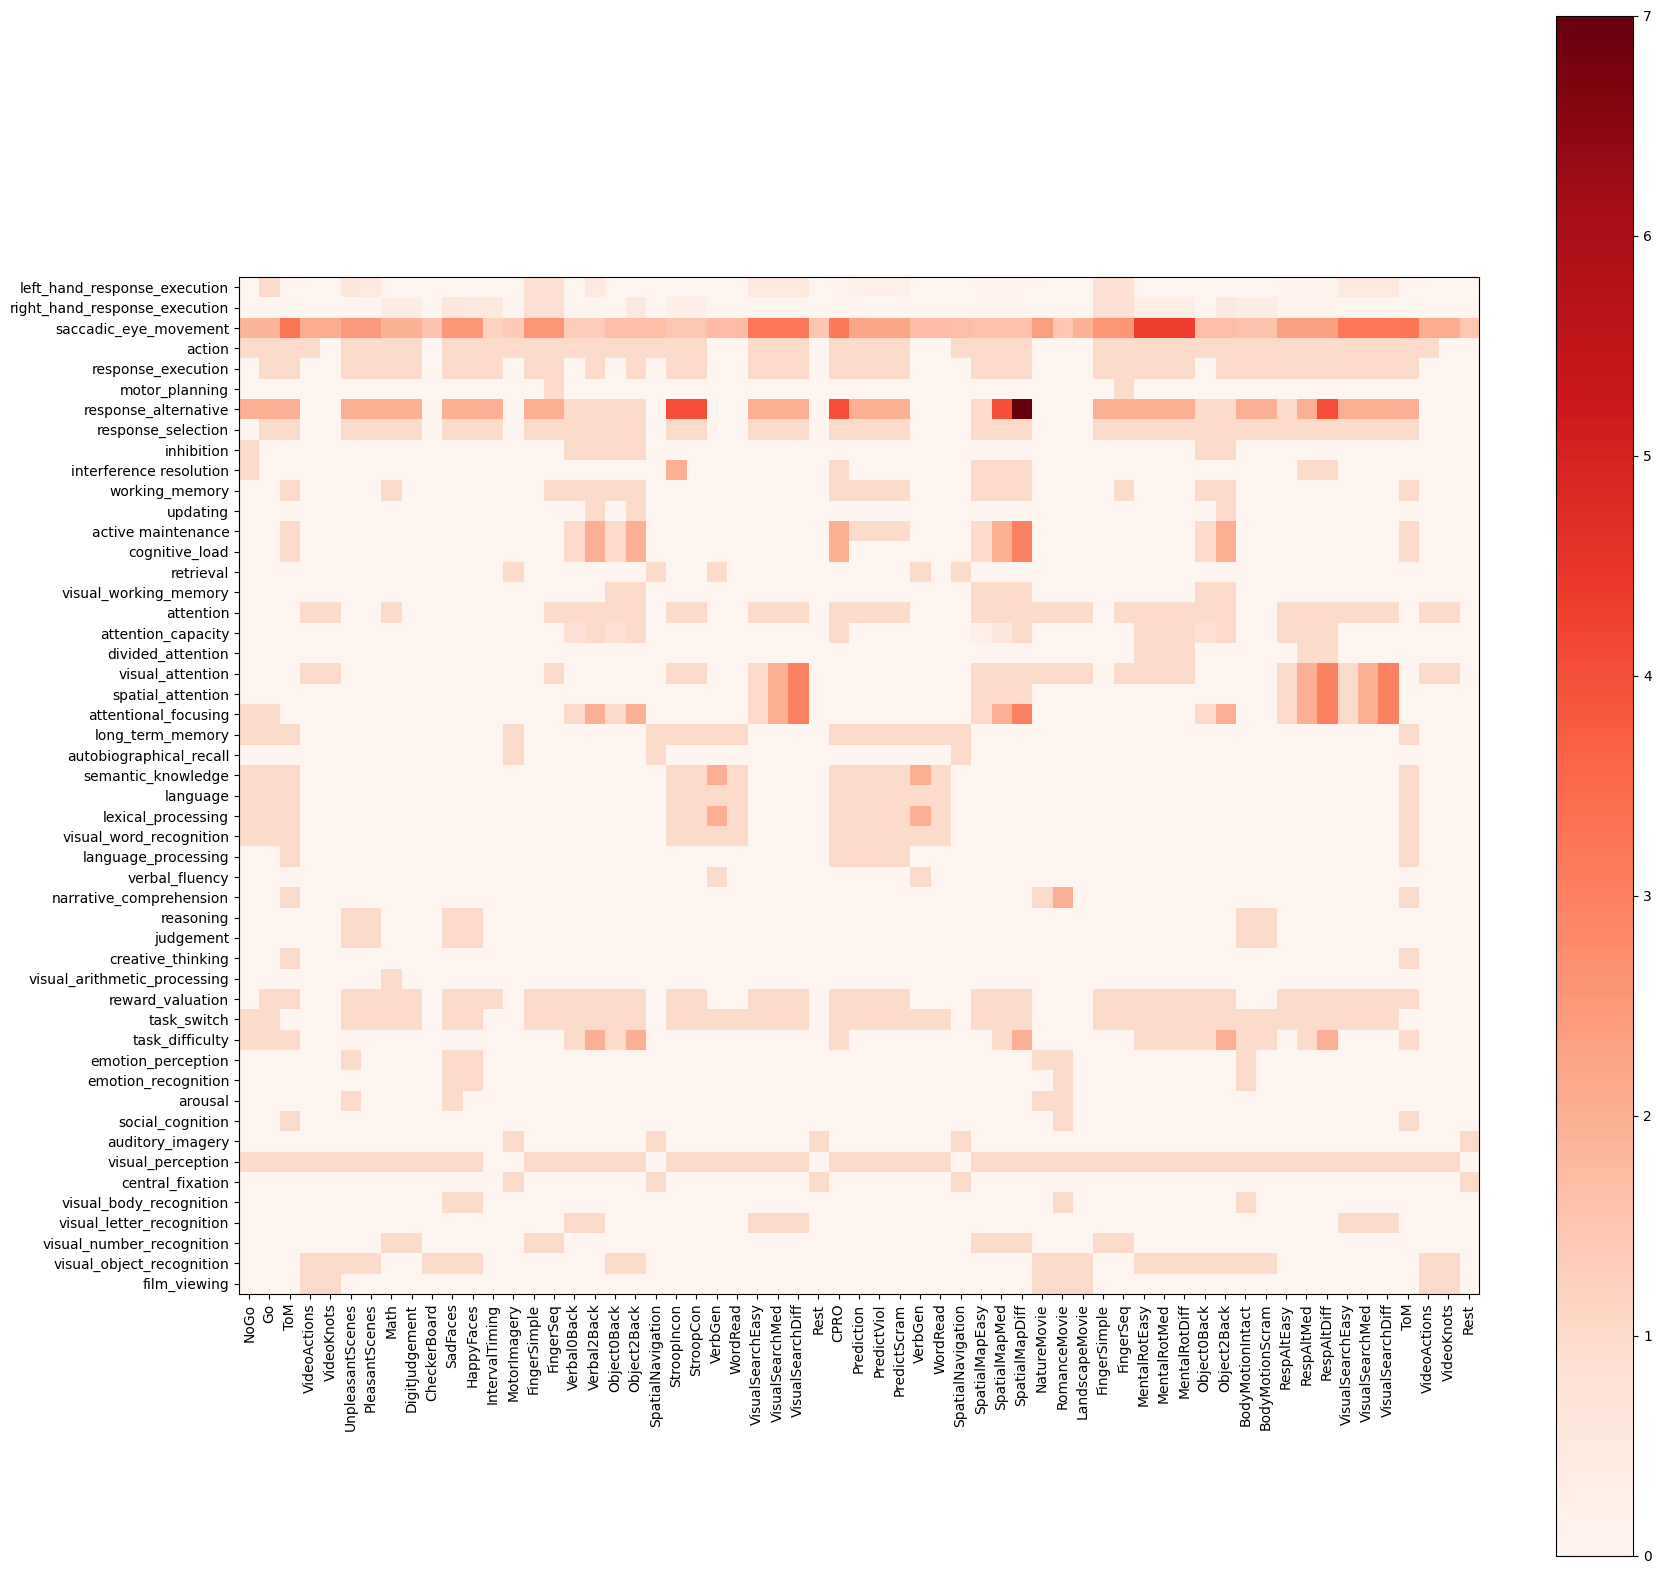

In [10]:
cmap_matrix = plt.get_cmap('Reds')

plt.figure(figsize=(20, 20))
plt.imshow(tags.T, cmap=cmap_matrix)
plt.xticks(range(tags.shape[0]), tags.index.tolist(), rotation=90)
plt.yticks(range(tags.shape[1]), tags.columns.tolist())
plt.colorbar()

In [11]:
# Repeat the tags for each participant
# Loop through the entries of profile.condition and repeat the tags.condition row 
mdtb_new = [
    "VideoAct",
    "VisualSearchSmall",
    "VisualSearchLarge",
    "SpatialMedDiff",
    "rest",
]
mdtb_old = [
    "VideoActions",
    "VisualSearchEasy",
    "VisualSearchMed",
    "SpatialMapDiff",
    "Rest",
]
mdtb_new2old = dict(zip(mdtb_new, mdtb_old))


for i, cond in enumerate(profile_orig.index):
    try:
        row = tags.iloc[tags.index.tolist().index(cond)]
    except:
        row = tags.iloc[tags.index.tolist().index(mdtb_new2old[cond])]
    if i == 0:
        tags_individ = row
    else:
        tags_individ = pd.concat([tags_individ, row], axis=1)




# Subtract mean from tags and divide by Std

In [12]:
# Subtract mean from each column and divide by standard deviation of each column
tags_individ = tags_individ.T
tags_mat = tags_individ.to_numpy()
tags_mat = (tags_mat - np.mean(tags_mat, axis=0)) / np.std(tags_mat, axis=0)

# Plot feature table

([<matplotlib.axis.YTick at 0x7ff55ab13070>,
 [Text(0, 0, 'NoGo'),
  Text(0, 1, 'Go'),
  Text(0, 2, 'ToM'),
  Text(0, 3, 'VideoAct'),
  Text(0, 4, 'VideoKnots'),
  Text(0, 5, 'UnpleasantScenes'),
  Text(0, 6, 'PleasantScenes'),
  Text(0, 7, 'Math'),
  Text(0, 8, 'DigitJudgement'),
  Text(0, 9, 'CheckerBoard'),
  Text(0, 10, 'SadFaces'),
  Text(0, 11, 'HappyFaces'),
  Text(0, 12, 'IntervalTiming'),
  Text(0, 13, 'MotorImagery'),
  Text(0, 14, 'FingerSimple'),
  Text(0, 15, 'FingerSeq'),
  Text(0, 16, 'Verbal0Back'),
  Text(0, 17, 'Verbal2Back'),
  Text(0, 18, 'Object0Back'),
  Text(0, 19, 'Object2Back'),
  Text(0, 20, 'SpatialNavigation'),
  Text(0, 21, 'StroopIncon'),
  Text(0, 22, 'StroopCon'),
  Text(0, 23, 'VerbGen'),
  Text(0, 24, 'WordRead'),
  Text(0, 25, 'VisualSearchSmall'),
  Text(0, 26, 'VisualSearchMed'),
  Text(0, 27, 'VisualSearchLarge'),
  Text(0, 28, 'rest'),
  Text(0, 29, 'CPRO'),
  Text(0, 30, 'Prediction'),
  Text(0, 31, 'PredictViol'),
  Text(0, 32, 'PredictScram'),


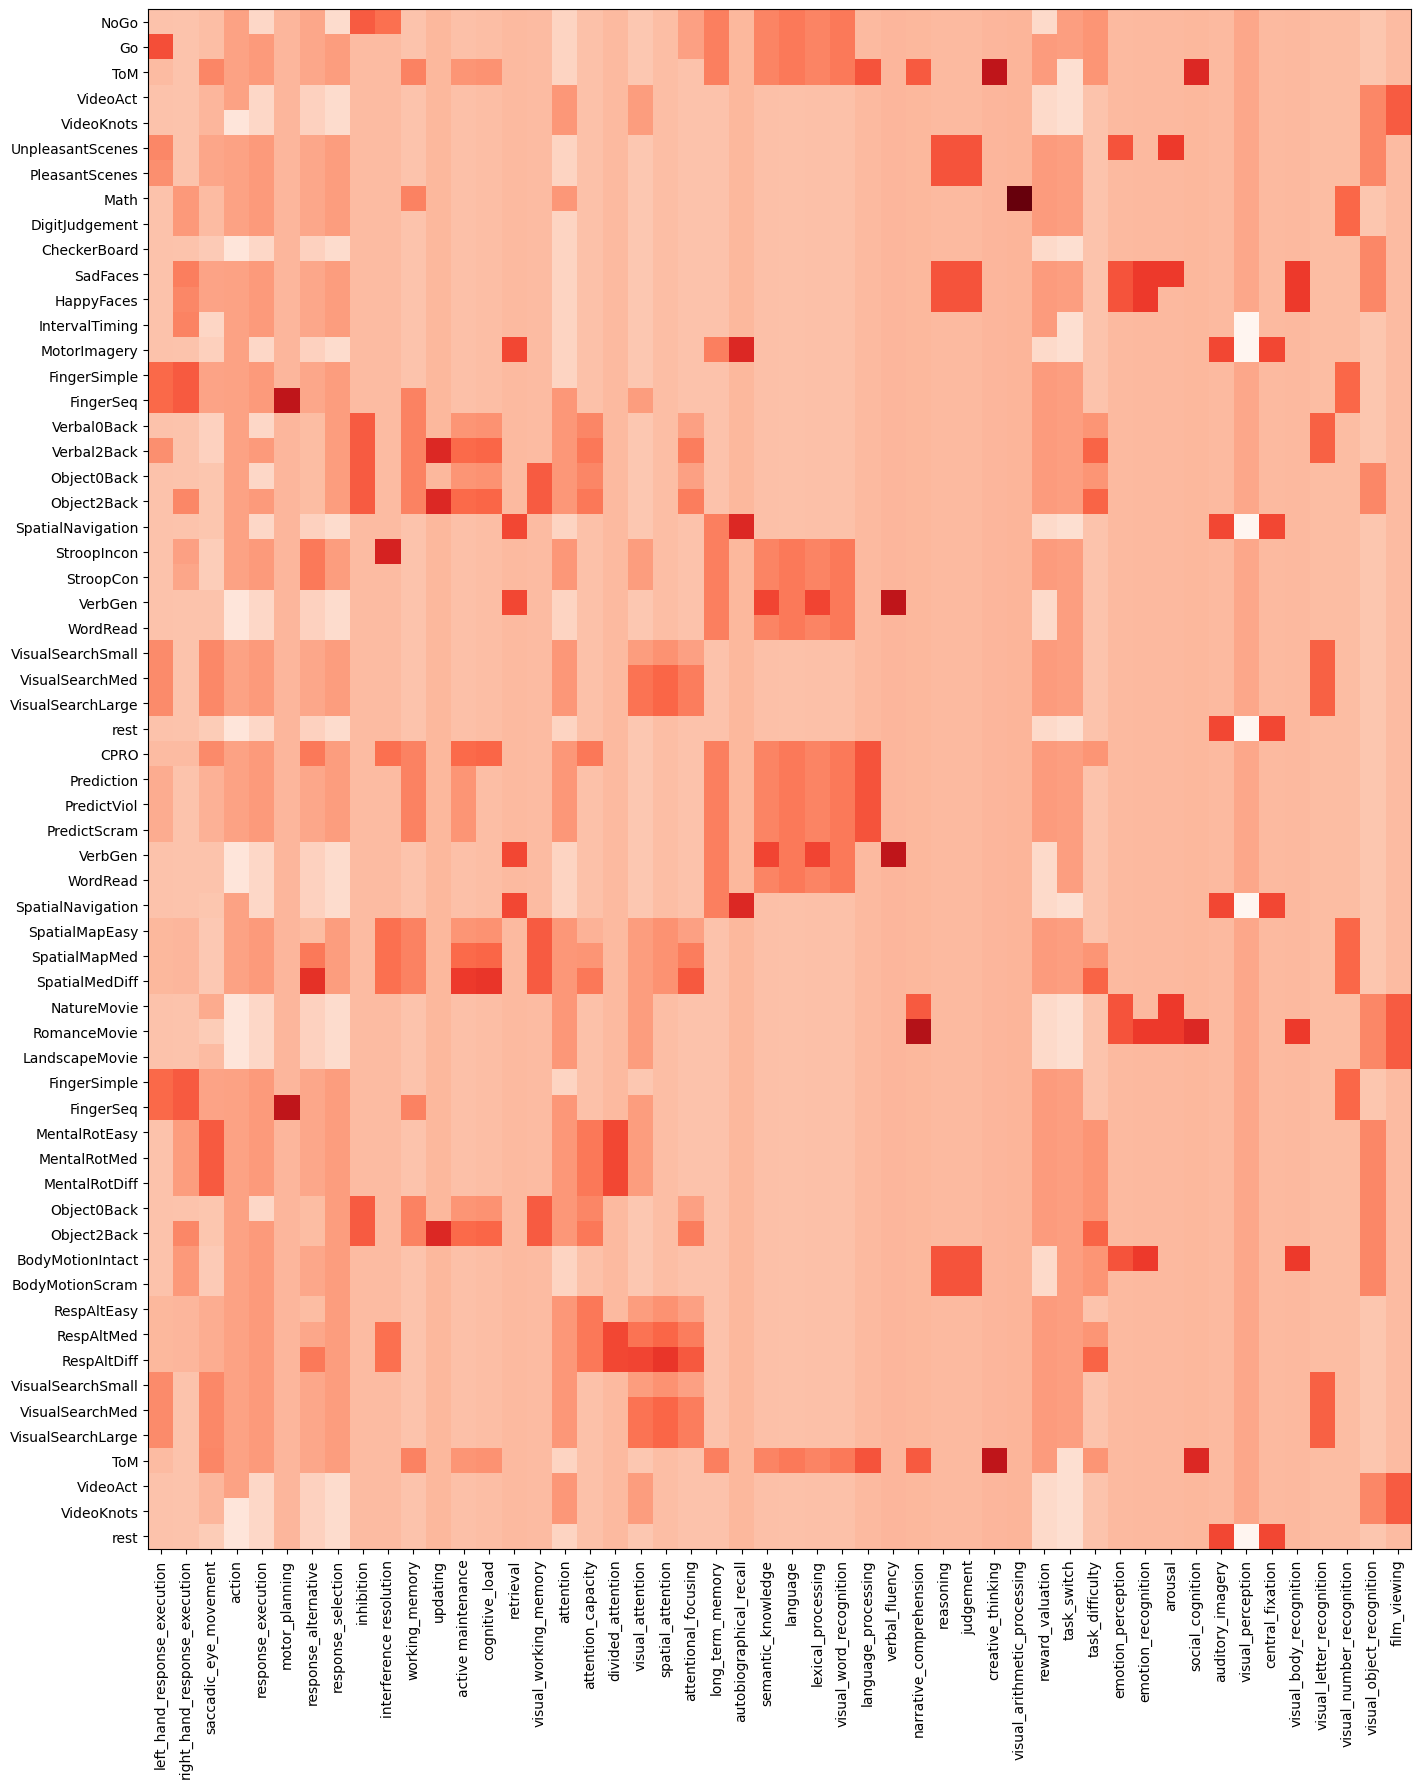

In [13]:
participant='02'
participant_rows = profile_orig.participant_id == f'sub-{participant}'

plt.figure(figsize=(20, 20))
plt.imshow(tags_mat[participant_rows], cmap=cmap_matrix)
plt.xticks(range(tags.shape[1]), tags.columns.tolist(), rotation=90)
plt.yticks(range(profile_orig[participant_rows].shape[0]), profile_orig[participant_rows].index.tolist())
# plt.colorbar()profile_orig

In [14]:
# Sum across tasks
tags_sum = tags.sum(axis=0)
# Show tags where the sum is larger than smaller than 2
tags_sum[tags_sum < 5]

motor_planning                  2.0
updating                        3.0
autobiographical_recall         3.0
verbal_fluency                  2.0
creative_thinking               2.0
visual_arithmetic_processing    1.0
emotion_recognition             4.0
arousal                         4.0
social_cognition                3.0
visual_body_recognition         4.0
dtype: float64

# Ridge Regression

In [15]:
profile_mat.shape

(1464, 32)

In [16]:
tags_mat.shape

(1464, 50)

In [17]:
R2, features = ridgeFit(profile_mat, tags_mat, fit_intercept=False, voxel_wise=False, alpha=1.0)
# Make dataframe with B values, profile.dataset, profile.condition, tags.columns[tags_first_tag_column:]
Features = pd.DataFrame(features.T, columns=tags.columns, index=labels)



# Plot Tasks

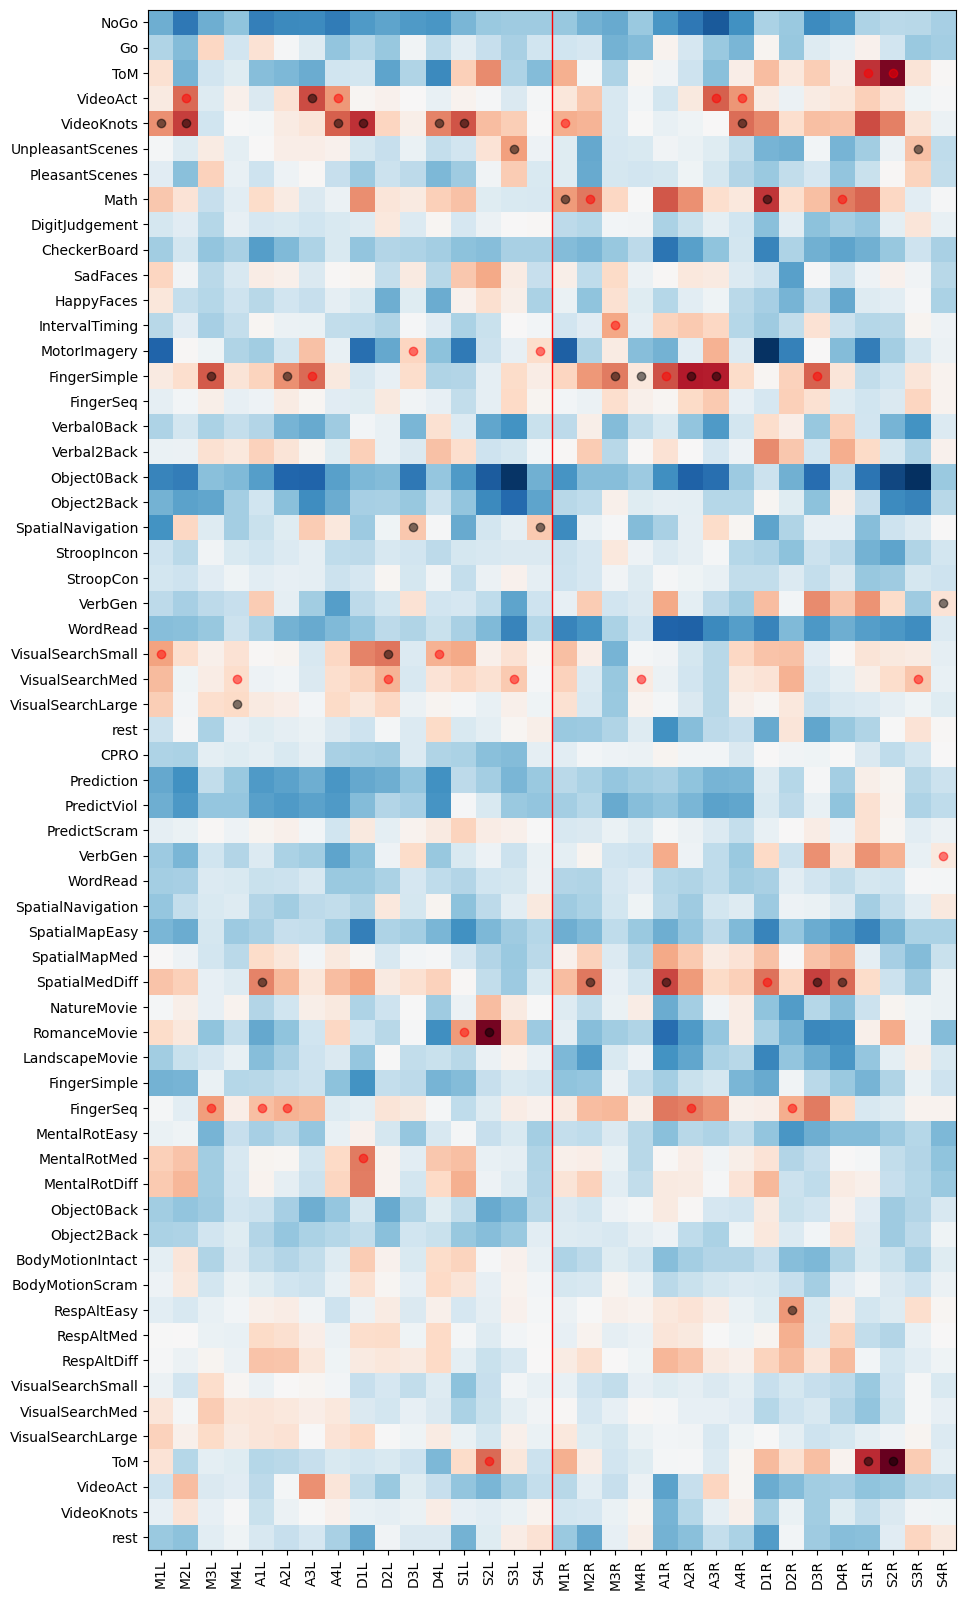

In [18]:
# Get diverging color map from matplotlib
cmap = plt.get_cmap('RdBu_r')
# Plot profile for one participant
participant='02'
tasks = profile[profile_orig.participant_id == f'sub-{participant}'].index

plt.figure(figsize=(20, 20))
plt.imshow(profile_mat[profile_orig.participant_id == f'sub-{participant}'], cmap=cmap)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(tasks)), tasks)
# Plot a medial line
plt.plot([len(labels)/2-0.5, len(labels)/2-0.5], [-0.5, len(tasks)-0.5], color='red', linewidth=1)

# mark the highest value in each column
n = 2
colors=['red', 'black']
for i in range(profile[profile_orig.participant_id == f'sub-{participant}'].shape[1]):
    # print(labels[i])
    # get the top n profile
    top_n = np.argsort(profile_mat[profile_orig.participant_id == f'sub-{participant}'][:, i])[-n:]
    # plot a dot at the top n profile
    for idx,j in enumerate(top_n):
        plt.plot(i, j, 'o', color=colors[idx], alpha=0.5)
    

# Plot Features

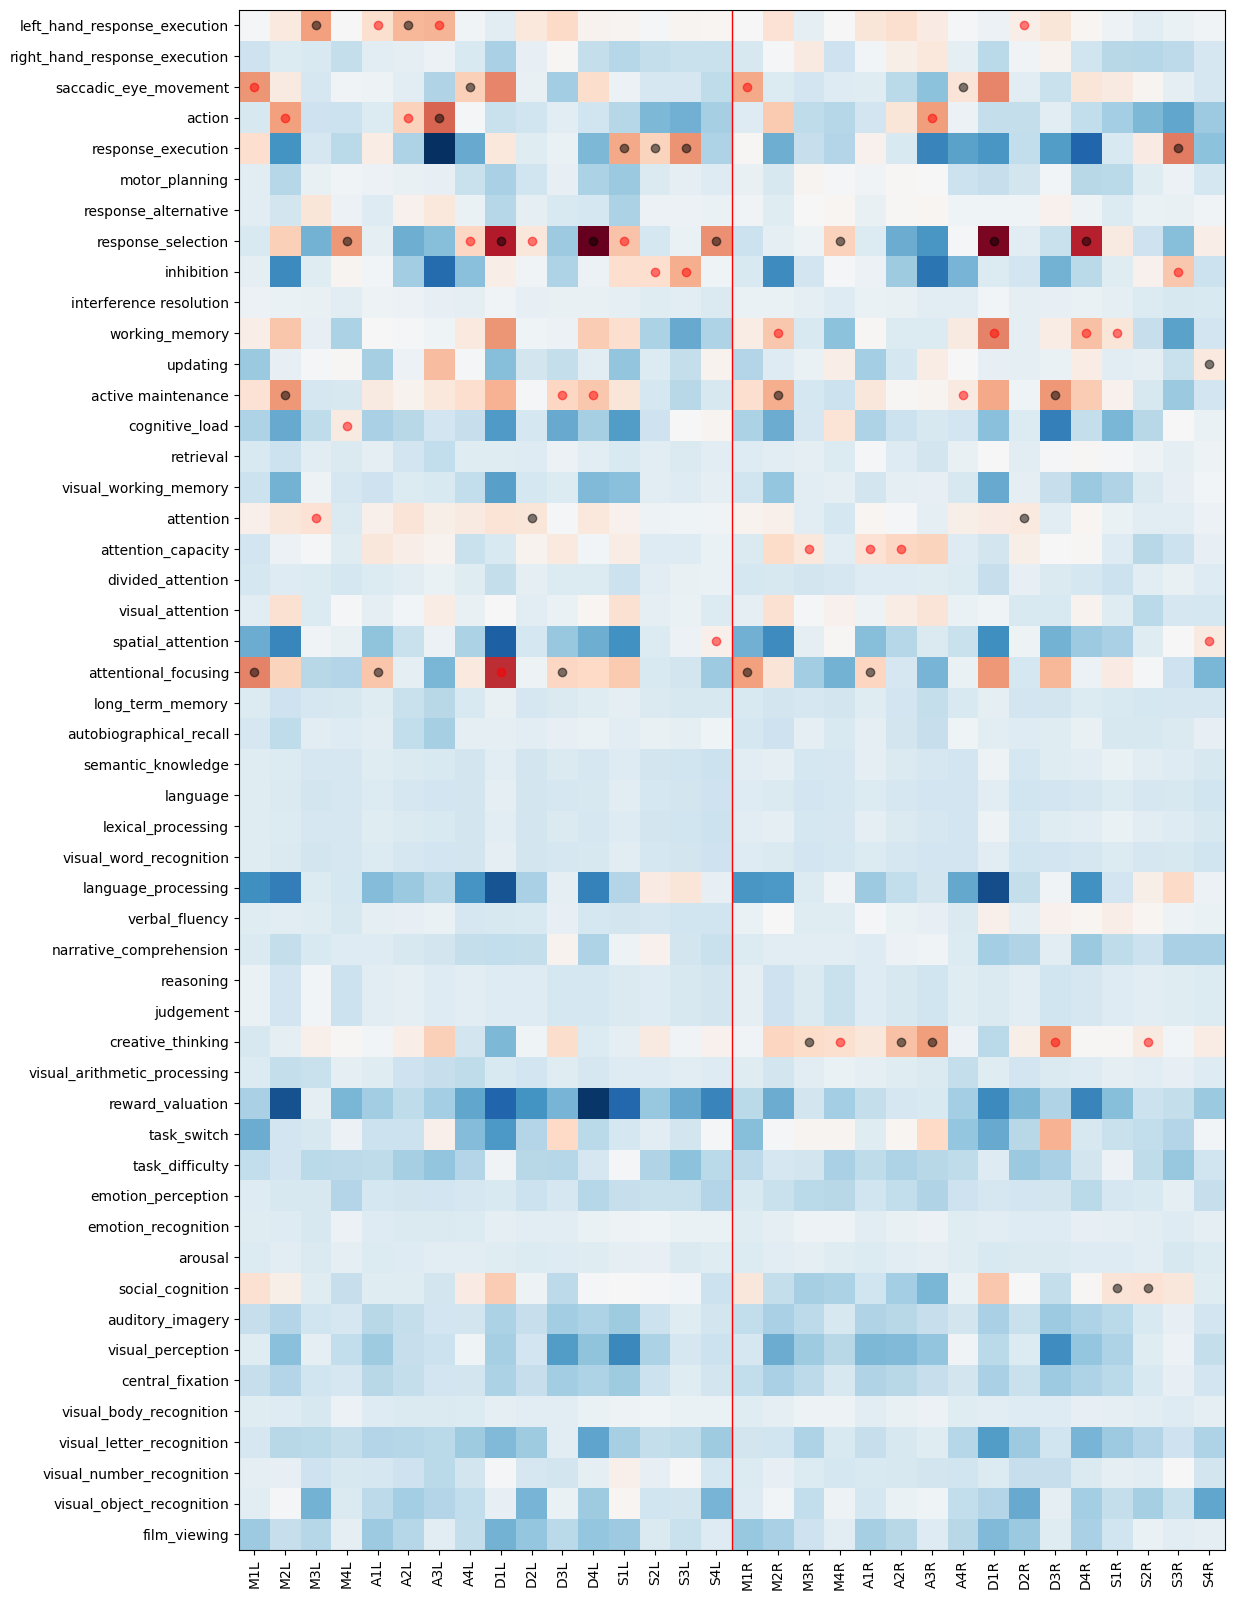

In [19]:
# Plot
plt.figure(figsize=(20, 20))
plt.imshow(features, cmap=cmap)
plt.xticks(np.arange(len(labels)), labels, rotation=90)
plt.yticks(np.arange(len(tags.columns)), tags.columns)
# Plot a medial line
plt.plot([len(labels)/2-0.5, len(labels)/2-0.5], [-0.5, len(tags.columns)-0.5], color='red', linewidth=1)

# mark the highest value in each column
colors=['red', 'black']
for i in range(features.shape[1]):
    # print(labels[i])
    # get the top n features
    top_n = np.argsort(features[:, i])[-n:]
    # plot a dot at the top n features
    for idx,j in enumerate(top_n):
        plt.plot(i, j, 'o', color=colors[idx], alpha=0.5)
        # print(tags.columns[j])
    

# Show highest features

In [20]:
def print_tags(profile, df, labels, region=None, n=5):

    for i, r in enumerate(labels):
        if (region is None) | (r == region):
            print(f'\nregion {r}')

            # Sort conditions by score
            scores = profile[:, i]
            zipped = zip(scores, df.columns)
            zipped = sorted(zipped, key=lambda x: x[0], reverse=True)
            scores, conds = zip(*zipped[:n])

            [print(f'{cond}: {score}')
             for score, cond in zip(scores, conds)]


In [21]:
for region in ['M1L', 'M1R']:
    print_tags(features, Features, labels, region=region, n=3)

for region in ['M2L', 'M2R']:
    print_tags(features, Features, labels, region=region, n=3)





region M1L
attentional_focusing: 0.029696646792055394
saccadic_eye_movement: 0.027064767692822657
response_execution: 0.014100662339909418

region M1R
attentional_focusing: 0.02570901586924546
saccadic_eye_movement: 0.024225233627156652
active maintenance: 0.01409273747772823

region M2L
active maintenance: 0.026561781082200104
action: 0.025664898228489996
working_memory: 0.01918824195580848

region M2R
active maintenance: 0.023475376731109183
working_memory: 0.018950220557180403
action: 0.018625428232768984


In [22]:

for region in ['M3L', 'M3R']:
    print_tags(features, Features, labels, region=region, n=2)

for region in ['M4L', 'M4R']:
    print_tags(features, Features, labels, region=region, n=2)


region M3L
left_hand_response_execution: 0.025646668082688985
attention: 0.012874521289749192

region M3R
creative_thinking: 0.014830637747011167
attention_capacity: 0.011033183879538081

region M4L
response_selection: 0.026586619684745808
cognitive_load: 0.010389396407090157

region M4R
response_selection: 0.017206841235496442
creative_thinking: 0.013759845387762447
